In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy import stats
import math
import numpy as np
import sys
import seaborn as sns
import matplotlib

def get_query_index_fastani_log(f):
    sketch_times = 0
    map_times = 0
    for line in open(f, 'r'):
        if 'sketching the reference' in line:
            sketch_times += float(line.split(':')[-1].split()[0])
        if 'spent mapping fragments' in line:
            map_times += float(line.split(':')[-1].split()[0])

    return map_times/(map_times + sketch_times)



def get_times_from_benchmark(f):
    counter = 0
    for line in open(f,'r'):
        if counter == 0:
            counter += 1
            continue
        else:
            spl = line.split('\t')
            wall_time = float(spl[0])
            max_rss = round(float(spl[2])/1000, 2)
            cpu_time = float(spl[-1])
            if cpu_time > 1:
                cpu_time = int(cpu_time)
            return [wall_time, cpu_time, max_rss]

def get_times_from_usrbintime(f):
    user_time = 0
    cpu_time = 0
    max_rss = 0
    wall_time = 0
    for line in open(f, 'r'):
        if 'User time' in line:
            user_time = float(line.split(':')[-1].rstrip())
        elif 'System time' in line:
            system_time = float(line.split(':')[-1].rstrip())
            cpu_time = user_time + system_time
        elif 'Maximum resident' in line:
            max_rss = round(float(line.split(':')[-1].rstrip())/1000000,2)
        elif 'wall clock' in line:
            str_time = line.split()[-1].rstrip()
            str_time = str_time.split(':');
            if len(str_time) == 3:
                wall_time = float(str_time[0]) * 3600 + float(str_time[1]) * 60 + float(str_time[2].rstrip())
            else:
                wall_time = float(str_time[0]) * 60 + float(str_time[1].rstrip())
    if cpu_time > 1:
        cpu_time = int(cpu_time)

    return [wall_time, cpu_time, max_rss]

     

# Change these parameters to get cpu-time, wall-time, memory vs runtime usage

In [3]:
##Change these parameters to get different plots. 
wall = False
time = False
log_scale = False
cmap = sns.color_palette("muted")

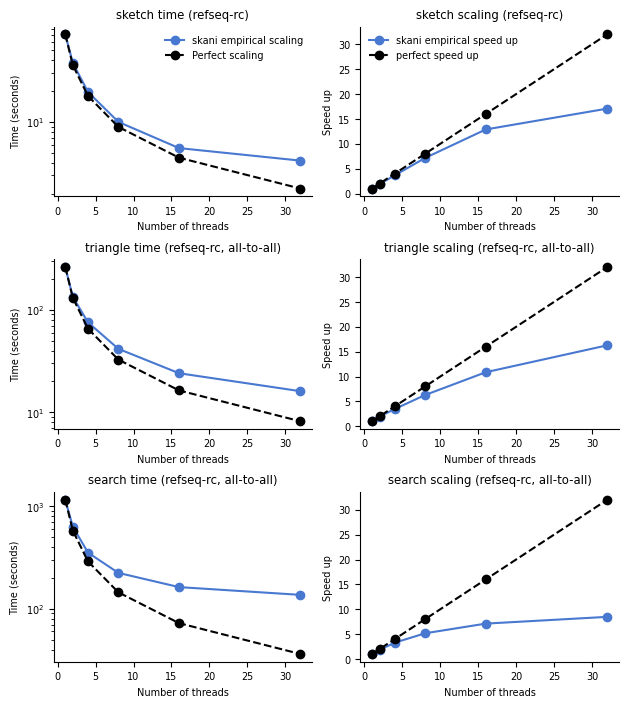

In [55]:
from natsort import natsorted
cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
if time:
    plt.figure(figsize=(18*cm, 8*cm))
else:
    plt.figure(figsize=(16*cm, 18*cm))


#plt.style.use(['nature'])
#plt.style.reload_library()

import glob
xs = [1,2,4,8,16,32]
def interp(x):
    return [x[0]/v for v in xs]

def speedup(x):
    return [x[0]/x[i] for i in range(len(x))]
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

times_sketch = "../thread_times/*sketch*"
times_tri = "../thread_times/*tri*"
times_search = "../thread_times/*search*"

files_sketch = natsorted(glob.glob(times_sketch))
files_tri = natsorted(glob.glob(times_tri))
files_search = natsorted(glob.glob(times_search))

plt.subplot(3,2,1)
wall_times_sketch = [get_times_from_usrbintime(x)[0] for x in files_sketch]
plt.plot([1,2,4,8,16,32],wall_times_sketch,'-o',c = cmap[0], label = 'skani empirical scaling')
plt.plot(xs, interp(wall_times_sketch), '--o',c = 'black', label = 'Perfect scaling')
plt.legend(frameon=False)
plt.yscale('log')
plt.ylabel('Time (seconds)')
plt.title("sketch time (refseq-rc)")
plt.xlabel("Number of threads")

plt.subplot(3,2,3)
wall_times_tri = [get_times_from_usrbintime(x)[0] for x in files_tri]
plt.plot([1,2,4,8,16,32],wall_times_tri,'-o',c = cmap[0])
plt.plot(xs, interp(wall_times_tri),  '--o',c = 'black')
plt.ylabel('Time (seconds)')
plt.title("triangle time (refseq-rc, all-to-all)")
plt.xlabel("Number of threads")

plt.yscale('log')
plt.subplot(3,2,5)
wall_times_search = [get_times_from_usrbintime(x)[0] for x in files_search]
plt.plot([1,2,4,8,16,32],wall_times_search,'-o',c = cmap[0])
plt.plot(xs, interp(wall_times_search),  '--o',c = 'black')
plt.ylabel('Time (seconds)')
plt.title("search time (refseq-rc, all-to-all)")

plt.yscale('log')
plt.xlabel("Number of threads")


plt.subplot(3,2,2)
wall_times_sketch = [get_times_from_usrbintime(x)[0] for x in files_sketch]
plt.plot(xs, speedup(wall_times_sketch), '-o',c = cmap[0], label = 'skani empirical speed up')
plt.plot(xs, xs,  '--o',c = 'black', label = 'perfect speed up')
plt.legend(frameon=False)
plt.ylabel('Speed up')
plt.title("sketch scaling (refseq-rc)")
plt.xlabel("Number of threads")

plt.subplot(3,2,4)
wall_times_tri = [get_times_from_usrbintime(x)[0] for x in files_tri]
plt.plot(xs, speedup(wall_times_tri),  '-o',c = cmap[0])
plt.plot(xs, xs,  '--o',c = 'black')

plt.ylabel('Speed up')
plt.title("triangle scaling (refseq-rc, all-to-all)")
plt.xlabel("Number of threads")

plt.subplot(3,2,6)
wall_times_search = [get_times_from_usrbintime(x)[0] for x in files_search]
plt.plot(xs, speedup(wall_times_search),  '-o',c = cmap[0])
plt.plot(xs, xs,  '--o',c = 'black')

plt.ylabel('Speed up')
plt.title("search scaling (refseq-rc, all-to-all)")

plt.xlabel("Number of threads")
plt.savefig("../final_figures/thread-runtimes.svg", bbox_inches='tight')


In [ ]:
#skani_time_index = get_times_from_usrbintime(skani_D3_index)
#skani_time_search = get_times_from_usrbintime(skani_D3_search)


if time:
    colours = [cmap[0], cmap[2], cmap[1]]

    wall_times_index = [skani_time_index[0], mash_time_index[0], int(fastani_time[0] * (1 - fastani_time_ratio)), ]
    cpu_times_index = [skani_time_index[1], mash_time_index[1],  int(fastani_time[1] * (1-fastani_time_ratio)), ]
    labels = ["skani","Mash", "FastANI*"]
    ax = plt.subplot(2,3,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if wall:
        bars = plt.barh([1,2,3], wall_times_index, log=log_scale, label=labels, tick_label = labels , color = colours)
        plt.xlabel("Wall time (seconds)")
    else:
        bars = plt.barh([1,2,3], cpu_times_index, log=log_scale, label=labels, tick_label = labels , color = colours)
        plt.xlabel("CPU time (seconds)")
    plt.bar_label(bars)
    #plt.hlines(y=skani_time_index[1] + skani_time_dist[1], xmin=1.5, xmax=3.5, linewidth=2, color=cmap[0], label = 'mash total time')
    #plt.hlines(y=mash_time_index[1] + mash_time_dist[1], xmin=4.5, xmax=6.5, linewidth=2, color=cmap[2], label = 'skani total time')
    plt.xticks(rotation = rot) # Rotates X-Axis Ticks by 45-degrees
    plt.title("Indexing time (E. colis)", fontsize = 7 )

    labels = ["skani search",  "Mash dist", "FastANI*"]
    ax = plt.subplot(2,3,4)
    wall_times_search= [skani_time_search[0], mash_time_dist[0], int(fastani_time[0] * fastani_time_ratio), ]
    cpu_times_search= [skani_time_search[1], mash_time_dist[1],  int(fastani_time[1] * fastani_time_ratio), ]

    colours = [cmap[0],  cmap[2], cmap[1]]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if wall:
        bars = plt.barh([1,2,3], wall_times_search, log=log_scale, label=labels, tick_label = labels , color = colours)
        plt.xlabel("Wall time (seconds)")
    else:
        bars = plt.barh([1,2,3], cpu_times_search, log=log_scale, label=labels, tick_label = labels , color = colours)
        plt.xlabel("CPU time (seconds)")
    plt.bar_label(bars)
    #ax.set_xlim(0,query_lim)
    plt.title("Querying+loading time (E. colis)", fontsize = 7 )